In [1]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from functions import read_images  , mergain , create_data_augmentation , show_rotated_image , show_zoomed_image , show_flipped_image

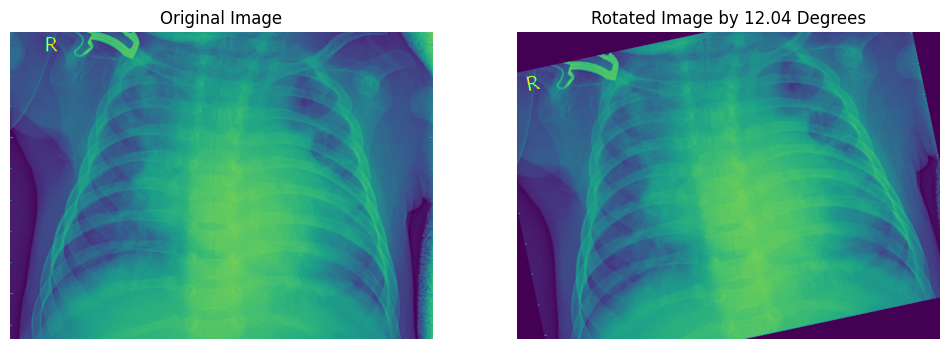

In [3]:
show_rotated_image("BACTERIA-103798-0001.jpeg")

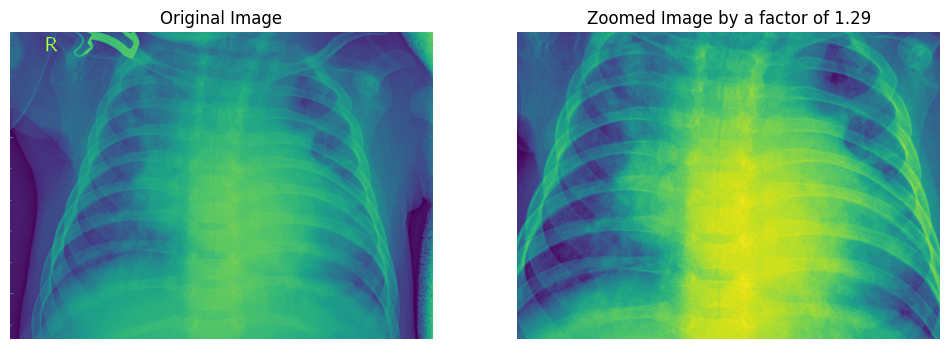

In [4]:
show_zoomed_image("BACTERIA-103798-0001.jpeg")

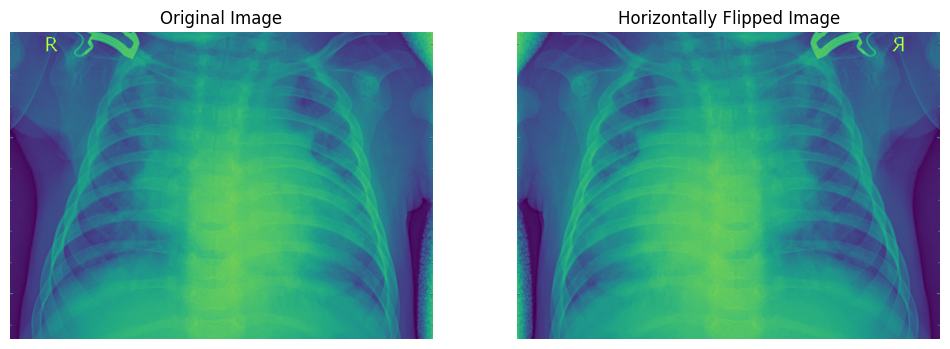

In [5]:
show_flipped_image("BACTERIA-103798-0001.jpeg")

In [2]:
clesses = os.listdir("C:\\Users\\LOQ\\Desktop\\BioSyncModels\\Data\\chest_xray")

In [3]:
pneumonia_images , pneumonia_train_labels = read_images(folder_path = "C:\\Users\\LOQ\\Desktop\\BioSyncModels\\Data\\chest_xray\\PNEUMONIA" , label =  1 , size = (128 , 128))
normal_images , normal_train_labels = read_images(folder_path = "C:\\Users\\LOQ\\Desktop\\BioSyncModels\\Data\\chest_xray\\NORMAL" , label =  0 , size = (128 , 128))

data , labels = mergain(pneumonia_images , normal_images , pneumonia_train_labels , normal_train_labels)
data = data / 255.0


train_data , test_data , train_labels , test_labels = train_test_split(data , labels , test_size = 0.3 , shuffle = True , stratify = labels)

train_data.shape , test_data.shape

((4099, 128, 128, 3), (1757, 128, 128, 3))

In [4]:
data_gen = create_data_augmentation().flow(train_data , train_labels , batch_size = 100)

imageShape = (128 , 128 , 3)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32 , 3 , activation = 'leaky_relu' , input_shape = imageShape))
model.add(tf.keras.layers.MaxPooling2D(2))

model.add(tf.keras.layers.Conv2D(32 , 3 , activation = 'leaky_relu'))
model.add(tf.keras.layers.MaxPooling2D(2))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(32 , 3 , activation = 'leaky_relu'))
model.add(tf.keras.layers.MaxPooling2D(2))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32 , 3 , activation = 'leaky_relu'))
model.add(tf.keras.layers.MaxPooling2D(2))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64 , 3 , activation = 'leaky_relu'))
model.add(tf.keras.layers.MaxPooling2D(2))




# model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(1 , activation = 'sigmoid'))

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9

In [5]:
learningRateReduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)

checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
        filepath = 'x_ray.model.h5',      
        monitor='val_loss',             
        save_best_only=True,           
        save_weights_only=False,    
        verbose=1
    )


callbacks = [learningRateReduction , checkpointCallback ]

In [6]:
history = model.fit(data_gen , epochs = 20, callbacks=callbacks , validation_data = (test_data , test_labels) , batch_size=100)

Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.7865
Epoch 1: val_loss improved from inf to 0.71685, saving model to x_ray.model.h5
41/41 [==============================] - 34s 213ms/step - loss: 0.4515 - accuracy: 0.7865 - val_loss: 0.7169 - val_accuracy: 0.2703 - lr: 0.0010
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8695
Epoch 2: val_loss improved from 0.71685 to 0.52029, saving model to x_ray.model.h5
41/41 [==============================] - 7s 170ms/step - loss: 0.2915 - accuracy: 0.8695 - val_loss: 0.5203 - val_accuracy: 0.8492 - lr: 0.0010
Epoch 3/20
41/41 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.8868
Epoch 3: val_loss improved from 0.52029 to 0.45093, saving model to x_ray.model.h5
41/41 [==============================] - 7s 167ms/step - loss: 0.2701 - accuracy: 0.8868 - val_loss: 0.4509 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 4/20
41/41 [======================

In [7]:
model = tf.keras.models.load_model('x_ray.model.h5')

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report , accuracy_score , precision_score , recall_score , f1_score

model_prediction = model.predict(test_data)

for i in range(len(model_prediction)):
    if model_prediction[i] > 0.50:
        model_prediction[i] = 1
    else:
        model_prediction[i] = 0


print(classification_report(test_labels , model_prediction))

print("Accuracy : ", accuracy_score(test_labels , model_prediction))

print("Precision : ", precision_score(test_labels , model_prediction))

print("Recall : ", recall_score(test_labels , model_prediction))

print("F1 : ", f1_score(test_labels , model_prediction))

55/55 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       475
           1       0.96      0.97      0.97      1282

    accuracy                           0.95      1757
   macro avg       0.94      0.93      0.94      1757
weighted avg       0.95      0.95      0.95      1757

Accuracy :  0.9493454752418896
Precision :  0.9620449264136328
Recall :  0.968798751950078
F1 :  0.9654100272055965


<Axes: >

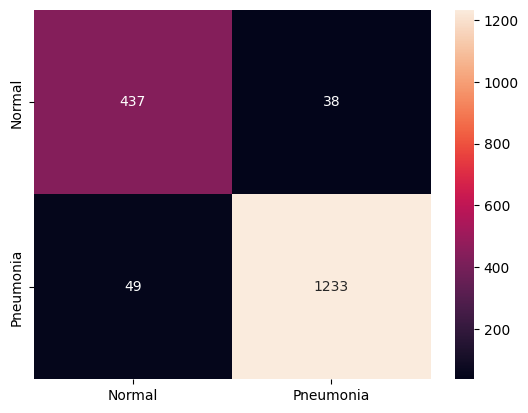

In [20]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
con = confusion_matrix(test_labels , model_prediction)
heatmap(con , annot = True , fmt = 'g' , xticklabels = ['Normal' , 'Pneumonia'] , yticklabels = ['Normal' , 'Pneumonia'])

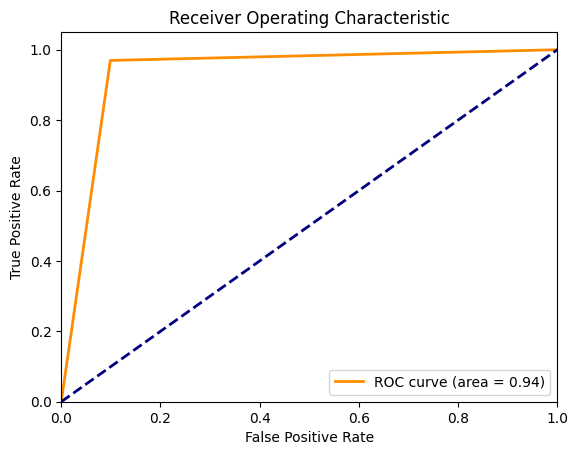

In [34]:
fpr, tpr, thresholds = roc_curve(test_labels, model_prediction)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

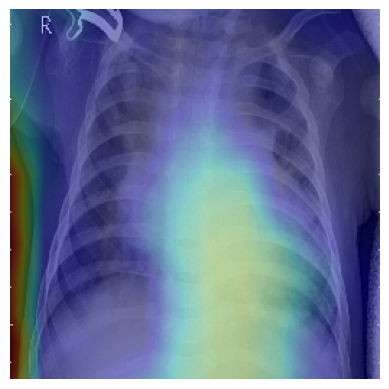

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize


# Load and preprocess an image
img_path = 'BACTERIA-103798-0001.jpeg'
img = load_img(img_path, target_size=(256, 256))  # Adjust size to model's expected input
img_array = img_to_array(img)
original_img = img_array.copy()
img_array = img_array/255.0
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Create Gradcam object
gradcam = Gradcam(model, model_modifier=None, clone=True)

# Define loss function for the 'African elephant' class index in VGG16
def loss(output):
    return (output)  # 386 is the class index for 'African elephant' in ImageNet

# Generate heatmap with Grad-CAM
heatmap = gradcam(loss, img_array, penultimate_layer=-1)  # Use the last convolutional layer
heatmap = normalize(heatmap)

# Visualization
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Original image')
# plt.imshow(img)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Grad-CAM')
plt.imshow(img)
plt.imshow(heatmap[0], cmap='jet', alpha=0.3)  # Overlay heatmap
plt.axis('off')
plt.savefig("myplot.png" , dpi = 300)
plt.show()


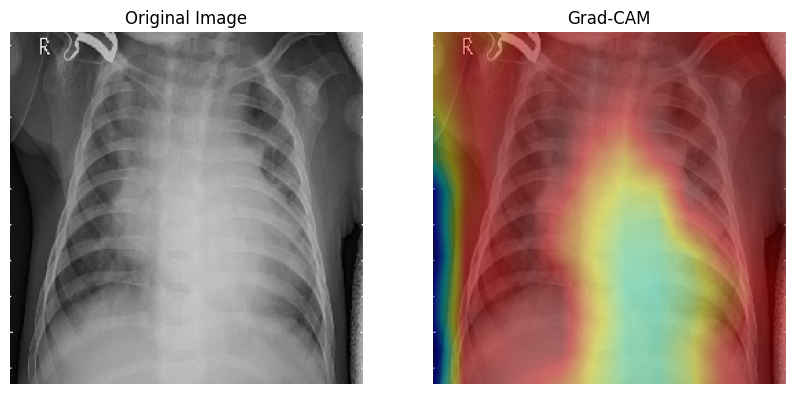

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
import cv2

# Load and preprocess an image
img_path = 'BACTERIA-103798-0001.jpeg'
img = load_img(img_path, target_size=(256, 256))  # Adjust size to model's expected input
img_array = img_to_array(img)
original_img = img_array.copy()
img_array = img_array/255.0
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Create Gradcam object
gradcam = Gradcam(model, model_modifier=None, clone=True)

# Define loss function for the 'African elephant' class index in VGG16
def loss(output):
    return (output)  # 386 is the class index for 'African elephant' in ImageNet

# Generate heatmap with Grad-CAM
heatmap = gradcam(loss, img_array, penultimate_layer=-1)  # Use the last convolutional layer
heatmap = normalize(heatmap)


heatmap = np.squeeze(heatmap)  # Remove unnecessary dimensions

# Resize heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

# Convert heatmap to RGB using a colormap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(original_img.astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_img / 255.0)  # Display original image
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(superimposed_img / 255.0)  # Display image with heatmap
plt.axis('off')

plt.show()

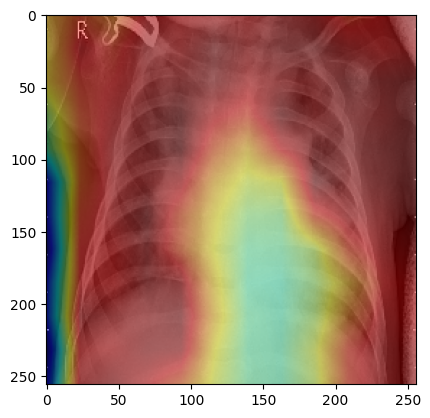

In [4]:
import matplotlib.pyplot as plt
plt.imshow(superimposed_img/255.0)